<table style="width: 100%; border-collapse: collapse;" border="0">
<tr>
<td><b>Created:</b> Monday 30 January 2017</td>
    <td style=\"text-align: right;\"><b> Original source: </b><a href=\"https://www.github.com/rhyswhitley/fire_limitation\">github.com/rhyswhitley/fire_limitation</td>
</tr>
<tr>
<td><b>Modified:</b> Friday 16 March 2018</td>
    <td style=\"text-align: right;\"><b> Current source: </b><a href=\"https://github.com/douglask3/UKESM_albedo_tile_optimization\">github.com/douglask3/UKESM_albedo_tile_optimization</td>
</tr>
</table>
<div>
<center>
<font face="Times">
<br>
<h1>Quantifying the uncertainity of UM tile & bare soil albedo using Bayesian inference</h1>
<h2>Part 1: Bayesian inference</h2>
<br>
<br>
Douglas Kelley<sup>1,* </sup>, 
Rich Ellis<sup>1 </sup>, 
Alistair Sellar<sup>2 </sup>,
Rhys Whitley<sup>3 </sup>
<br>
<br>
<br>
<sup>1 </sup>Centre for Ecology and Hydrology, Maclean Building, Crowmarsh Gifford, Wallingford, Oxfordshire, United Kingdom
<br>
<sup>2 </sup>Met Office United Kingdom, Exeter, United Kingdom
<br>
<sup>3 </sup>Natural Perils Pricing, Commercial & Consumer Portfolio & Pricing, Suncorp Group, Sydney, Australia
<br>
<br>
<h3>Summary</h3>
<hr>
<p> 
Yay and Wow
</p>
<br>
<br>
<br>
<i>Python code and calculations below</i>
<br>
</font>
</center>
<hr>
</div>

### Model description
There are two options to determine the surface albedo($\alpha$). We start by optimizing the simplest option, described in Best et al. 2011. A vegetative tile albedo ($\alpha_pft$) is calculated from the PFTs leaf albedo (\alpha_{\infty}) and the underlying soil albedo ($\alpha_b$). The amount of light that makes it to the ground, and therefore the balance of the conbrtibution of $\alpha_{\infty}$ to $\alpha_b$, follows a simple extiction curve through the canopy based on the PFTs Leaf Area Index ($LAI$):

\begin{eqnarray}
    \alpha_{pft} &=& \alpha_b \cdot e^{-k \cdot LAI}  + \alpha_{\infty} \cdot ( 1 - e^{-k \cdot LAI} )
\end{eqnarray}
Where $-k$ is a $PFT$ specific extinction rate parameter.

None vegetated tiles have a single albedo value ($\alpha_{tile}$). The albedo of a cell is the weighed albedo of all tiles:

\begin{eqnarray}
    \alpha = \sum_{pft} C_{pft} \cdot \alpha_{pft}(\alpha_{b}, \alpha_{\infty, pft}, k_{pft}, LAI_{pft}) +
             \sum_{tile} C_{tile} \cdot \alpha_{tile} + C_{b} \cdot \alpha_{b}
\end{eqnarray}

where $C_i$ is the fractional cover of PFT, non vegetated and bare soil tiles.

We will optimized over the 9 PFTs desciebed in ..., 3 non-vegetated tiles from ... and bare soil. Bare soil will need a value per grid cell, but to keep things simple to start with, we will use one global bare soil value. We will therefore be optimizing 18 vegetation paramters ($k$ and $alpha_{\infty}$ for each PFT), 3 non-vegetated paramters ($\alpha_{tile}$ for each tile) and $\alpha_b$. 22 paramters in total.
 

### Load libraries

In [4]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('../')

# data munging and analytical libraries 
import re
import os
import numpy as np
import pandas as pd
import iris

# optimization libraries
import pymc3 as pm3 
from pymc3.backends import SQLite
from scipy import optimize
from theano import tensor as tt


# graphical libraries
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
from   libs.plot_maps    import *

# setup nice plotting
plt.style.use('ggplot')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import and clean data

Set the directory path and look for all files that correspond to the model drivers and target.

In [5]:
data_dir = '/users/global/doukel/ukesm_prj/JULES_UKESM_albedo/data/'

Files = ["qrclim.land",
         "qrparm_frac_27_tile_orca1_cci.anc",
         "qrparm_func_orca1_13_tile.anc",
         "qrparm.soil"]

unknown_stash = {"m01s00i216": "FRACTIONS OF SURFACE TYPES",
                 "m01s00i207": "UNFILTERED OROGRAPHY",
                 "m01s00i008": "SOIL BULK DENSITY   KG/M3"}



data = list()
for i in Files:
    cubes = iris.load(data_dir + i)
    for i in cubes: data.append(i)

#for i in data: print(i.stash())

#def stash(cube):
for code in unknown_stash:
    for cube in data:
        if cube.attributes['STASH'] == code: cube.long_name = unknown_stash[code]

## 2.1 Model definition

Could possibly contain this in a class object, but I'm not sure theano can instantiate the object to be used by the GPU. If I've made absolutely no sense just then, then I would leave the following as is.

In [6]:

from pdb import set_trace as browser
def pft_albedo(albedo_bare, albedo_inf, k, LAI):
    extinct = np.exp(-k * LAI)
    albedo = albedo_bare * extinct + albedo_inf * (1 - extinct)
    return albedo
    
def cell_albedo(cover_pft, cover_tile, cover_bare, albedo_bare, albedo_inf, k, LAI, albedo_tile):
    veg = [C * pft_albedo(albedo_bare, inf, ki, lai) for C, inf, ki, lai in zip(cover_pft, albedo_inf, k, LAI)]
    non = [C * alb for C, alb in zip(cover_tile, albedo_tile)]
    albedo = np.sum(veg + non + [cover_bare * albedo_bare])
    return albedo

#def albedo(cover_pft, cover_tile, cover_bare, *args, **kw):
    
    

### 2.1.1 Old configuration

In [7]:
pft_code    = [101, 102, 103, 201, 202, 501, 502,   3,   4]
albedo_inf  = [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2]
k           = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

tile_code   = [   6,    7,    9]
albedo_tile = [0.18, 0.06, 0.75]

bare_code   = [8]

In [25]:
def select_data(name):
    for i in data:
        if i.name() == name: return i
        
def select_pseudo_level(cube, codes):
    code = cube.coord('pseudo_level').points
    ids = [np.where(code == id)[0][0] for id in  codes]
    return cube[ids]

cover       = select_data('FRACTIONS OF SURFACE TYPES')
LAI         = select_data('leaf_area_index')
albedo_bare = select_data('soil_albedo')
albedo_obs  = select_data('surface_diffuse_albedo_assuming_no_snow')

cover_pft   = select_pseudo_level(cover,  pft_code)
cover_tile  = select_pseudo_level(cover, tile_code)
cover_bare  = select_pseudo_level(cover, bare_code)
LAI         = select_pseudo_level(LAI, pft_code)

surface_diffuse_albedo_assuming_no_snow / (1) (month_number: 12; latitude: 144; longitude: 192)
     Dimension coordinates:
          month_number                                     x             -               -
          latitude                                         -             x               -
          longitude                                        -             -               x
     Auxiliary coordinates:
          month                                            x             -               -
     Scalar coordinates:
          forecast_period: 0 hours
     Attributes:
          STASH: m01s00i243
          source: Data from Met Office Unified Model
     Cell methods:
          mean: time


In [28]:
albedo = albedo_obs.copy()
albedo.data = cell_albedo(cover_pft.data, cover_tile.data, cover_bare.data, albedo_bare.data, albedo_inf, k, LAI.data, albedo_tile)

/users/global/doukel/anaconda3/lib/python3.6/site-packages/iris/coords.py:975: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/users/global/doukel/anaconda3/lib/python3.6/site-packages/iris/coords.py:975: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/users/global/doukel/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


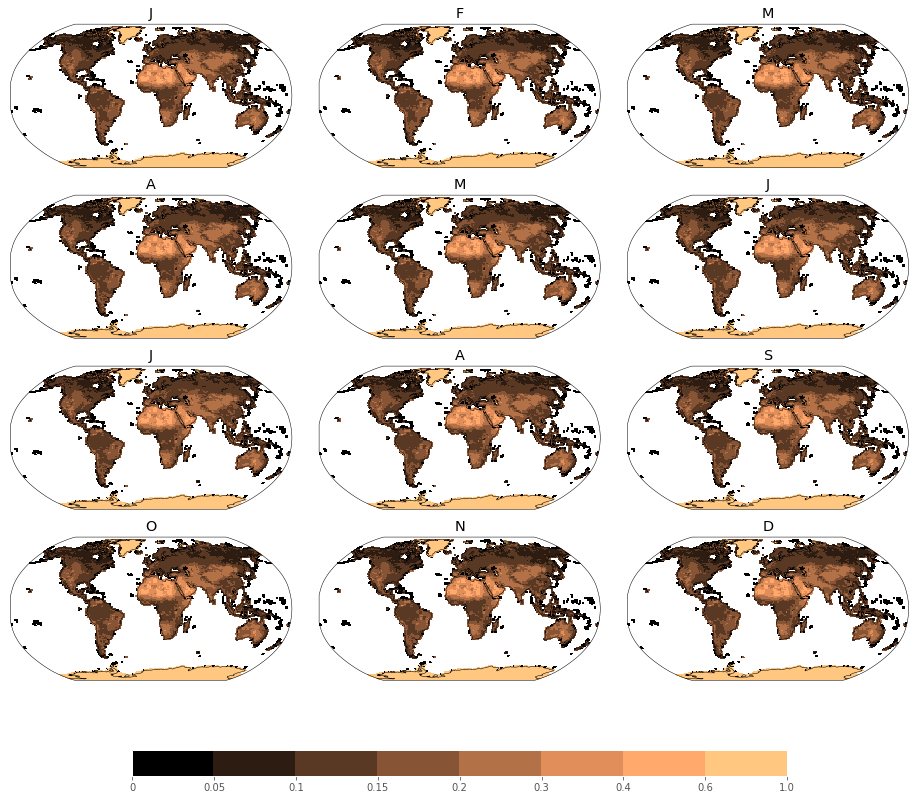

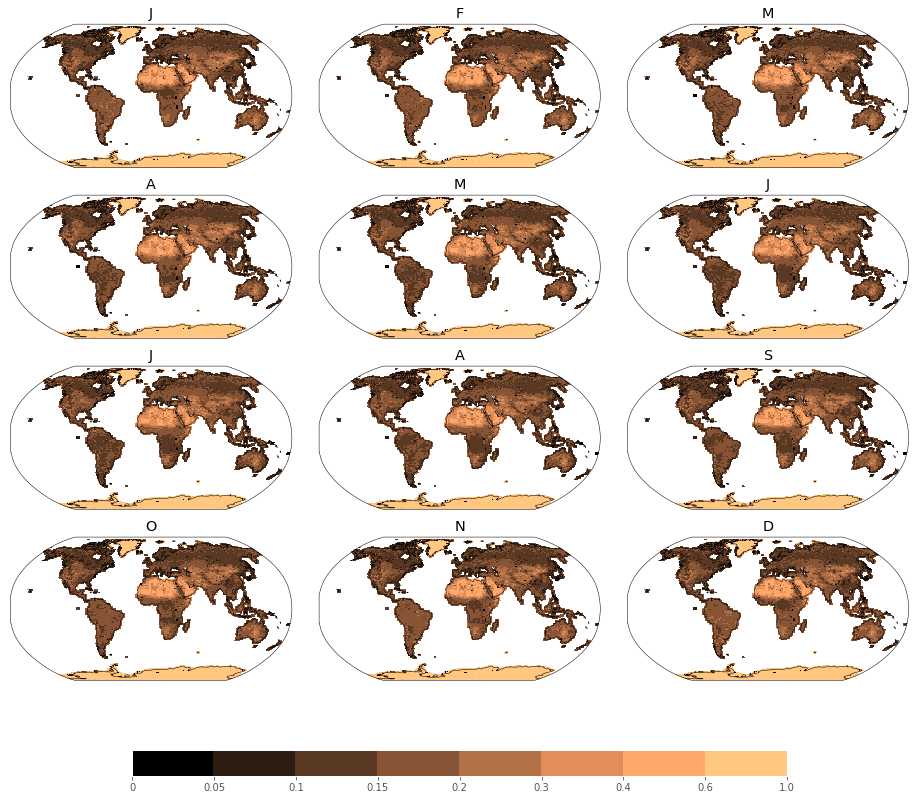

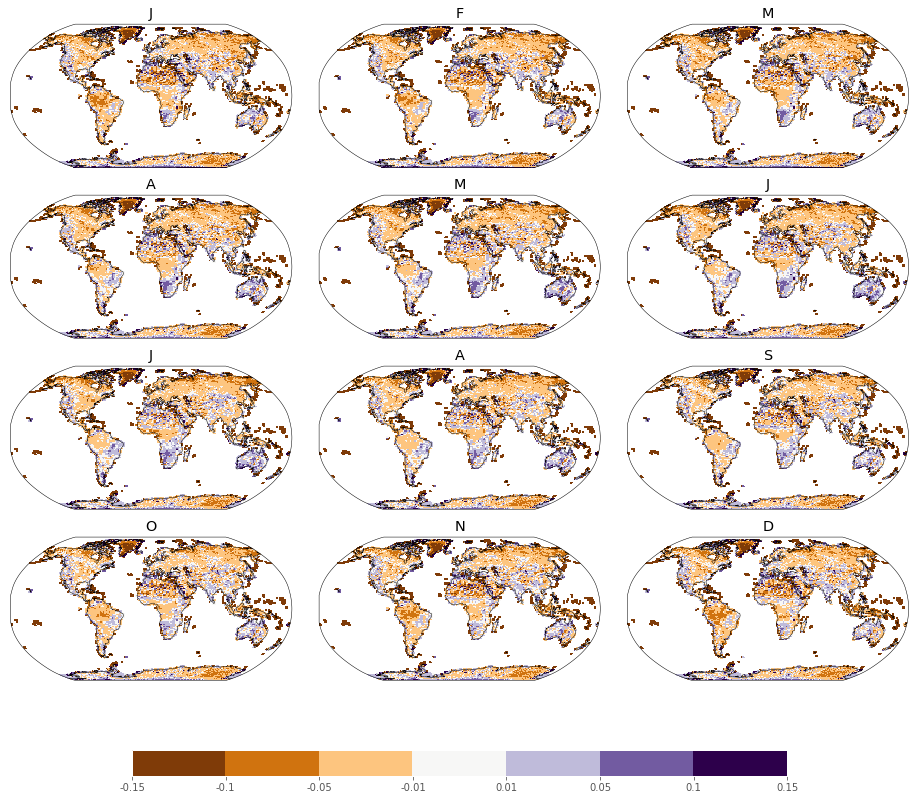

In [35]:
month_names = 'JFMAMJJASOND'
albedo_levels = [0, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.6, 1.0]
albedo_diff_levels = [-0.15, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.15]

def plot_month_data(cubes, cmap = 'copper', levels = albedo_levels):
    plot_cubes_map(cubes, month_names, cmap, levels, ny = 3,  figXscale = 1.3)
    
    
plot_month_data(albedo)
plot_month_data(albedo_obs)

albedo_dif = albedo - albedo_obs
plot_month_data(albedo_dif, 'PuOr', albedo_diff_levels)

## 2.2 Import data

Load data and do any necessary transformation needed for the Bayesian modelling framework. For testing purposes I've limited the number of rows I'm importing (here about 100K). If you plan to do the full dataset, then delete the `nrows` variabe in the cell below. 

In [3]:
DATAPATH = os.path.expanduser(outPath)

fd = pd.read_csv(DATAPATH, nrows=1e5)

Do a sanity check to make sure our data has imported correctly.

In [4]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
alpha                  100000 non-null float64
cropland               100000 non-null float64
fire                   100000 non-null float64
lightning_ignitions    100000 non-null float64
NPP                    100000 non-null float64
pasture                100000 non-null float64
population_density     100000 non-null float64
urban_area             100000 non-null float64
dtypes: float64(8)
memory usage: 6.1 MB


## 2.3 Baysian framework

A simple explanation of Baye's law is:

\begin{equation}
    P(\beta|X) \propto P(\beta)\cdot P(X|\beta)
\end{equation}

where $X$ is our data (observations of some arbitrary system), and $\beta$ our set of unexplained parameters that describe the reponse of our _proposed understanding_ of this system as it varies with $X$.

### 2.3.1 Prior definitions
Because I have no idea what the uncertainty on the hyper parameters should look like (beyond $\beta> 0$), I've set them all as uniform. Some of them can possibly be describe as exponential or half-normal, due to the physical nature of $\beta$, but we can play around with that later.

\begin{eqnarray}
    P(\beta) &=& \prod_{i=1}^{4}P(a_i)\prod_{i=1}^{4}P(b_i)\cdot P(\sigma)\cdot P(k_c)P(k_p)P(k_{d,1})P(k_{d,2}) \\[1.5em]
    P(a) = P(b) = P(\sigma) &=& \mathcal{N}(0, 1) \\[1em]
    P(k_c) = P(k_p) = P(k_{d,1}) = P(k_{d,2}) &=& \mathcal{U}(\beta_{\min}, \beta_{\max}) \\[1.5em]
\end{eqnarray}

I'm not totally sure about the maths above being right, but it's just to show that _full_ prior is normal. Important, because we'll also describe the error (likelihood) as normal, such that the posterior is therefore normal (conjugate); i.e. $\mathcal{N}\times\mathcal{N}=\mathcal{N}$ (expansion happens in the mean of the exponent). 

Back to the code.., `pymc3` is quite funky in that it allows me to create an empty `Model()` object and just add things to it as I need them using a `with` statement. I've called our Bayesian model `fire_error` as that is what we are trying to Quantify.



In [5]:
with pm3.Model() as fire_error:
    
# first for the sigmoids (the 4's at the end state that I want 4 of them)
    a_s4 = pm3.Normal('sig_a', mu=0, sd=100, shape=4)
    b_s4 = pm3.Normal('sig_b', mu=0, sd=100, shape=4)
    
# now for the hyper-parameters that describe the independent fire condition covariates

    kp = pm3.Normal('kp', mu=500, sd=100)
    kd1 = pm3.Normal('kd1', mu=500, sd=100)
    kd2 = pm3.Normal('kd2', mu=500, sd=100)

#    kp = pm3.Uniform('kp', 0, 1e3)
#    kd1 = pm3.Uniform('kd1', 0, 1e3)
#    kd2 = pm3.Uniform('kd2', 0, 1e3)
    
# describe the standard deviation in the error term
    sigma = pm3.HalfNormal('sigma', sd=1)

### 2.3.2 Likelihood definition

For the sake of simplicity (and because I don't really know any better), we define the model error as normally distributed (i.i.d.) although it most likely isn't. We could make this more complicated later by defining the error as heteroscedastic, but I wouldn't bother with that until we have some idea of the convergence. We're describing the error (observations minus model predictions) as follows:

\begin{eqnarray}
    P(X|\beta) &=& \mathcal{N}(F_{burn}, \sigma) \\[1em]
    \mathcal{N}(F_{burn}, \sigma) &=& \frac{N}{\sigma\sqrt{2\pi}}\exp\left\{\sum_{i=1}^{N}\left(\frac{y_i - F_{burn, i}}{\sigma_i}\right)^2\right\}
\end{eqnarray}

where $y_i$ is a set of observations we're attempting to optimise on. Below is the code that describes the above:

In [6]:
with fire_error:
    
    # transform hyper-covariates 
    x_1 = fd["NPP"].values
    
    x_2 = fd["alpha"].values
    
    x_3 = ignition(fd["lightning_ignitions"].values, \
                   fd["pasture"].values, \
                   fd["population_density"].values, \
                   kp, kd1)
    
    x_4 = supression(fd["cropland"].values, \
                     fd["population_density"].values, \
                     kd2)
    
    # list of primary covariates
    xs = [x_1, x_2, x_3, x_4]
    Nx = len(xs)
    
    # burnt area is assumed to be the product of the 4 sigmoids
    prediction = np.product([tt_sigmoid(xs[i], a_s4[i], b_s4[i]) for i in range(Nx)])
    
    # calculate the error between observed and predicted burnt area
    error = pm3.Normal('error', mu=prediction, sd=sigma, observed=fd['fire'].values)

### 2.3.3 Posterior sampling

Because it is nigh impossible to determine the posterior solution analytically we will instead sample the information space to **infer** the posterior solutions for each of the model parameters. In this case we are using a Metropolis-Hasting step MCMC.

I've tried using No-U-Turn (NUTS) sampling (which is the new kid on the block), but there are issues with it's current implementation in pymc3 (see github repo issues). Can use it once problems are ironed out - but TBH it doesn't matter if we're getting a reasonable convergence.

In [7]:
with fire_error:
    
    # help the sampling out by quickly finding an optimal start position
    start = pm3.find_MAP(model=fire_error.model, fmin=optimize.fmin_powell)
    
    # set the step-method (criteria algorithm for moving around information space)
    step = pm3.Metropolis()
    
    # save our sampling to disk so we can access it later
    db_save = SQLite('../data/firemodel_trace.db')
    
    # do the sampling
    mcmc_traces = pm3.sample(5e3, step=step, start=start, njobs=-1, trace=db_save)

Optimization terminated successfully.
         Current function value: -293612.186103
         Iterations: 8
         Function evaluations: 1426


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000.0 [13:37<00:00,  6.00it/s]


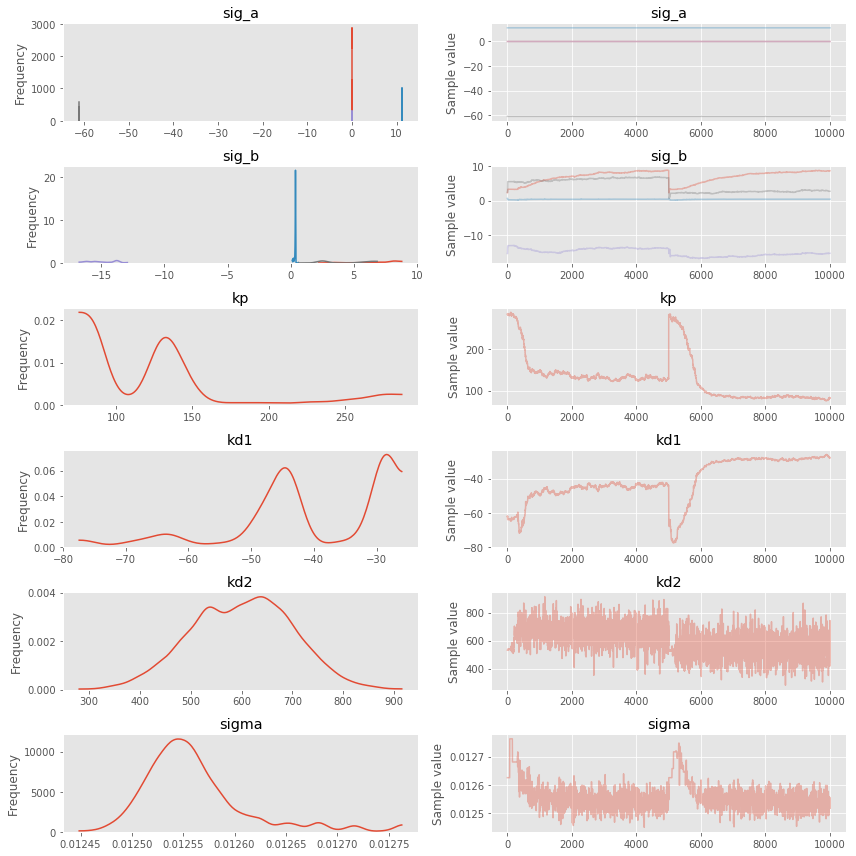

In [8]:
pm3.traceplot(mcmc_traces);

In [9]:
type(mcmc_traces)

pymc3.backends.base.MultiTrace